In [1]:
from folktables import ACSDataSource, ACSEmployment
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

2024-05-23 12:04:23.167976: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-23 12:04:23.830124: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [31]:
data_src = ACSDataSource(survey_year="2018", horizon="1-Year", survey="person")
acs_data = data_src.get_data(states=["CA"], download=True)
features, labels, group = ACSEmployment.df_to_numpy(acs_data)

In [33]:
df = pd.DataFrame(features)
df.columns = ACSEmployment.features
df[ACSEmployment.target] = labels
clear_data = df.copy()
n_labels = np.array(clear_data.pop("ESR"))
n_features = clear_data.copy()
print(n_features.shape, " vs ", features.shape)
x_train, x_test, y_train, y_test, group_train, group_test = train_test_split(
    n_features, n_labels, group, test_size=0.2, random_state=0)

(378817, 16)  vs  (378817, 16)


In [34]:
print(sum(y_train[(group_train == 2)]), " vs ", sum(y_train[(group_train == 1)]))
di = np.mean(y_train[(group_train == 2)]) / np.mean(y_train[(group_train == 1)])
print("Disparate impact : ", di, f"[{len(y_train[(group_train == 1)])}]")

5702  vs  85639
Disparate impact :  0.8529905307925469 [186364]


In [35]:
input_shape = x_train.shape[1:]

def get_model(input_shape):
    tf.keras.utils.set_random_seed(0)
    model = tf.keras.models.Sequential([
        tf.keras.Input(input_shape),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(16, activation="relu"),
        #tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy"), tf.keras.metrics.Recall(name="recall"), 
                     tf.keras.metrics.AUC(name="auc")])
    return model

In [36]:
model1 = get_model(input_shape)
model2 = get_model(input_shape)
print("Training model...", end="")
model1.fit(x_train, y_train, epochs=50, verbose=False)
model2.fit(x_train, y_train, epochs=50, verbose=False)
print("Done")

Training model...Done


In [37]:
yhat1 = model1.predict(x_test)
yhat2 = model2.predict(x_test)
l = yhat1 == yhat2
print(sum([x==False for x in l]), ' | ', l.shape)

2368/2368 ━━━━━━━━━━━━━━━━━━━━ 1s 390us/step
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 1s 395us/step
[0]  |  (75764, 1)


2368/2368 ━━━━━━━━━━━━━━━━━━━━ 1s 362us/step
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 1s 381us/step


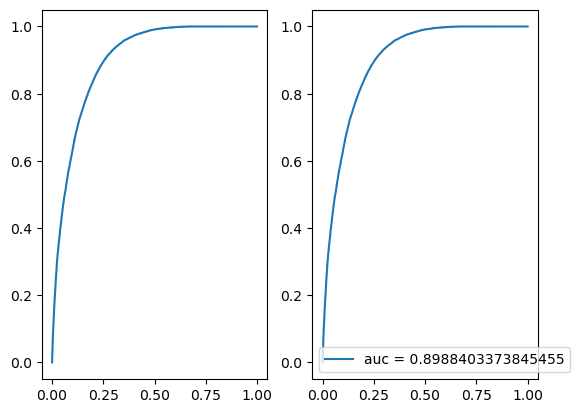

In [38]:
from sklearn import metrics
import matplotlib.pyplot as plt

fig,(ax1, ax2) = plt.subplots(1, 2)
yhat = model1.predict(x_test)
fpr, tpr, _ = metrics.roc_curve(y_test, yhat)
auc = metrics.roc_auc_score(y_test, yhat)
ax1.plot(fpr, tpr, label="auc = "+str(auc))
yhat = model2.predict(x_test)
fpr, tpr, _ = metrics.roc_curve(y_test, yhat)
auc = metrics.roc_auc_score(y_test, yhat)
ax2.plot(fpr, tpr, label="auc = "+str(auc))
plt.legend()
plt.show()

In [39]:
import math
def fairness(model, x_test, y_test, group_test):
    yhat = np.round(model.predict(x_test))
    ev = model.evaluate(x_test, y_test)
    acc = float(format(ev[1], "0.4f"))
    rec = float(format(ev[2], ".4f"))
    #acc = float(format(np.mean(yhat[(y_test == 1)]), "0.4f"))

    p_grp_tpr = np.mean(yhat[(y_test == 1) & (group_test == 1)])
    up_grp_tpr = np.mean(yhat[(y_test == 1) & (group_test == 2)])
    if math.isnan(p_grp_tpr):
        p_grp_tpr = 0
    if math.isnan(up_grp_tpr):
        up_grp_tpr = 0
    
    # equality of difference (opportinuty)
    eod = float(format(abs(p_grp_tpr - up_grp_tpr), ".4f"))

    # statistical parity difference
    p_grp = np.mean(yhat[(group_test == 1)])
    up_grp = np.mean(yhat[(group_test == 2)])
    if math.isnan(p_grp):
        p_grp = 0
    if math.isnan(up_grp):
        up_grp = 0
    spd = float(format(abs(p_grp - up_grp), ".4f"))

    return {"EOD": eod, "SPD": spd, "ACC": acc, "REC": rec}

stats1 = fairness(model1, x_test, y_test, group_test)
stats2 = fairness(model2, x_test, y_test, group_test)

2368/2368 ━━━━━━━━━━━━━━━━━━━━ 1s 373us/step
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 1s 415us/step - accuracy: 0.8185 - auc: 0.8997 - loss: 0.3863 - recall: 0.8511
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 1s 369us/step
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 1s 413us/step - accuracy: 0.8185 - auc: 0.8997 - loss: 0.3863 - recall: 0.8511


{'EOD': 0.0245, 'SPD': 0.0648, 'ACC': 0.8177, 'REC': 0.8507}


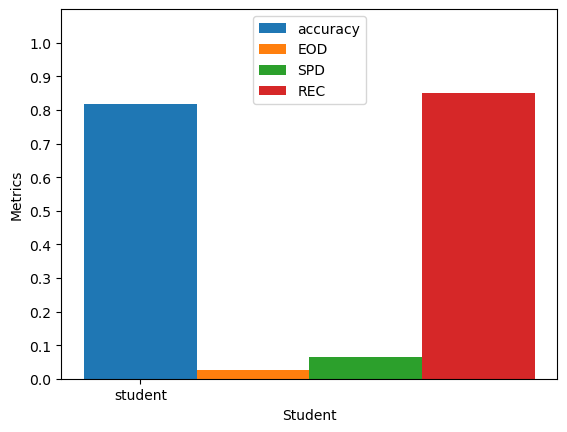

{'EOD': 0.0245, 'SPD': 0.0648, 'ACC': 0.8177, 'REC': 0.8507}


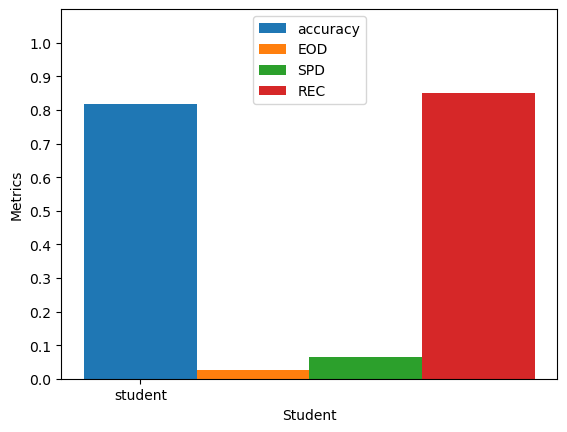

In [40]:
def plot(stats):
    print(stats)
    colors = plt.rcParams["axes.prop_cycle"].by_key()['color']
    b_width=0.3
    plt.bar([1], [stats["ACC"]], width=b_width, color=colors[0], label="accuracy")
    plt.bar([1+b_width], [stats["EOD"]], width=b_width, color=colors[1], label="EOD")
    plt.bar([1+2*b_width], [stats["SPD"]], width=b_width, color=colors[2], label="SPD")
    plt.bar([1+3*b_width], [stats["REC"]], width=b_width, color=colors[3], label="REC")
    plt.xticks([1+3*b_width/2], [""])
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.ylim([0,1.1])
    plt.xlabel(f"Student")
    plt.ylabel("Metrics")
    plt.legend()
    plt.show()
    
plot(stats1)
plot(stats2)

### Testing dirichlet

In [41]:
p_grp_pr = df[(df["RAC1P"] == 1) & (df["ESR"] == True)]
up_grp_pr = df[(df["RAC1P"] == 2) & (df["ESR"] == True)]
rest_of_df = df[((df["RAC1P"] != 1) & (df["RAC1P"] != 2)) | (df["ESR"] == False)]

In [42]:
print(p_grp_pr.shape, ' | ', up_grp_pr.shape, " | ", rest_of_df.shape)

(106659, 17)  |  (7168, 17)  |  (264990, 17)


In [43]:
p_vs_up = pd.concat([p_grp_pr, up_grp_pr])

In [44]:
p_vs_up.shape

(113827, 17)

In [45]:
print(p_grp_pr.shape[0]/p_vs_up.shape[0], ' vs ', up_grp_pr.shape[0]/p_vs_up.shape[0])

0.9370272430969805  vs  0.0629727569030195


In [46]:
dist = np.random.dirichlet([100,100], 1)
print(dist[0])
size_p_grp = int(dist[0][0]*p_vs_up.shape[0])
size_up_grp = p_vs_up.shape[0]-size_p_grp
print("p_grp : ", size_p_grp, " | up_grp : ", size_up_grp)

[0.53292098 0.46707902]
p_grp :  60660  | up_grp :  53167


In [47]:
p_grp = p_grp_pr.sample(size_p_grp, replace=True)
up_grp = up_grp_pr.sample(size_up_grp, replace=True)

In [48]:
final_df = pd.concat([p_grp, up_grp, rest_of_df])
final_df.shape

(378817, 17)

In [49]:
n_clear_data = final_df.copy()
n_labels = np.array(n_clear_data.pop("ESR"))
n_features = n_clear_data.copy()
n_group = n_clear_data["RAC1P"]

n_x_train, n_x_test, n_y_train, n_y_test, n_group_train, n_group_test = train_test_split(
    n_features, n_labels, n_group, test_size=0.2, random_state=0)

In [50]:
n_input_shape = n_x_train.shape[1:]
n_model = get_model(n_input_shape)

2368/2368 ━━━━━━━━━━━━━━━━━━━━ 1s 392us/step
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 1s 419us/step - accuracy: 0.8324 - auc: 0.9168 - loss: 0.3652 - recall: 0.8491
{'EOD': 0.2591, 'SPD': 0.5671, 'ACC': 0.8345, 'REC': 0.8478}


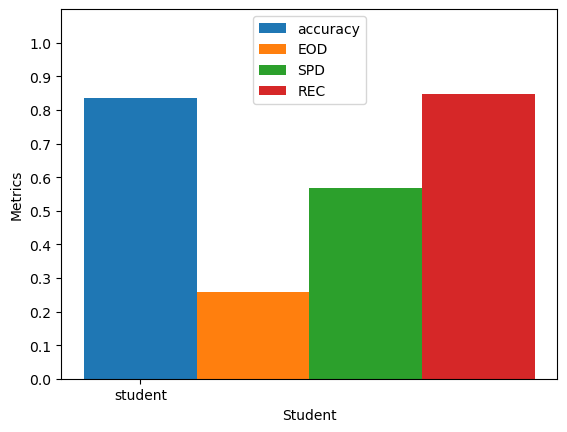

In [51]:
n_model.fit(n_x_train, n_y_train, epochs=50, verbose=False)
n_stats = fairness(n_model, n_x_test, n_y_test, n_group_test)
plot(n_stats)

2368/2368 ━━━━━━━━━━━━━━━━━━━━ 1s 389us/step
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 1s 422us/step - accuracy: 0.8324 - auc: 0.9168 - loss: 0.3652 - recall: 0.8491
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 1s 398us/step
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 1s 421us/step - accuracy: 0.8324 - auc: 0.9168 - loss: 0.3652 - recall: 0.8491
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 1s 399us/step
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 1s 431us/step - accuracy: 0.8324 - auc: 0.9168 - loss: 0.3652 - recall: 0.8491
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 1s 381us/step
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 1s 407us/step - accuracy: 0.8324 - auc: 0.9168 - loss: 0.3652 - recall: 0.8491
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 1s 383us/step
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 1s 412us/step - accuracy: 0.8324 - auc: 0.9168 - loss: 0.3652 - recall: 0.8491


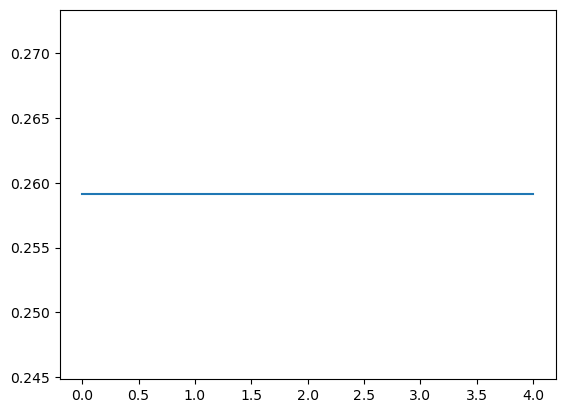

In [52]:
y_axis = []
for _ in range(5):
    dist = np.random.dirichlet([100,100], 1)
    size_p_grp = int(dist[0][0]*p_vs_up.shape[0])
    size_up_grp = p_vs_up.shape[0]-size_p_grp
    p_grp = p_grp_pr.sample(size_p_grp, replace=True)
    up_grp = up_grp_pr.sample(size_up_grp, replace=True)
    final_df = pd.concat([p_grp, up_grp, rest_of_df])
    n_clear_data = final_df.copy()
    n_labels = np.array(n_clear_data.pop("ESR"))
    n_features = n_clear_data.copy()
    n_group = n_clear_data["RAC1P"]

    n_x_train, n_x_test, n_y_train, n_y_test, n_group_train, n_group_test = train_test_split(
        n_features, n_labels, n_group, test_size=0.2, random_state=0)
    
    n_input_shape = n_x_train.shape[1:]
    n_model = get_model(n_input_shape)
    n_model.fit(n_x_train, n_y_train, epochs=50, verbose=False)
    n_stats = fairness(n_model, n_x_test, n_y_test, n_group_test)
    y_axis.append(n_stats["EOD"])
plt.plot(list(range(5)), y_axis)
plt.show()